In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp given_models

# given_models
> i.e. routines for setting up and using pretrained AutoEncoder models

Currently included:
- Baselines: Spectrogram (i.e. complex STFT), MagSpectrogram, MelSpectrogram
- Diffusion models: DVAE (unmasked)

To be added:
- Diffusion models: masked DVAE , archinet's
- Others groups': JukeBox (as "IceBox"), RAVE,...? 

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
from __future__ import annotations  # for type hints LAION code samples
import numpy as np 
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms as T
import pytorch_lightning as pl
import math
from tqdm import trange


# audio-diffusion imports
from copy import deepcopy
import pytorch_lightning as pl
from diffusion.pqmf import CachedPQMF as PQMF
from encoders.encoders import AttnResEncoder1D
from autoencoders.soundstream import SoundStreamXLEncoder
from dvae.residual_memcodes import ResidualMemcodes
from decoders.diffusion_decoder import DiffusionAttnUnet1D
from diffusion.model import ema_update
from einops import rearrange

from audio_algebra.DiffusionDVAE import DiffusionDVAE, sample

In [ ]:
# imports not needed for library but used in documentation/tests/demo
import matplotlib.pyplot as plt
from aeiou.viz import playable_spectrogram, audio_spectrogram_image, tokens_spectrogram_image
from aeiou.core import load_audio
from aeiou.datasets import Stereo
from aeiou.hpc import freeze
from IPython.display import display, HTML  # just for displaying inside notebooks

We're going to make a bunch of wrappers that are PyTorch modules. The API for the wrappers will be as follows: 
- `.encode()`: encodes the (batch of) (raw) audio waveform(s) into encodings aka "representations" `reps`
- `.decode()`: decodes the (batch of) encodings/representations from the encoder into "reconstructions" `recons`
- `.forward()`: calls *both* `encode()` and `decode()` in succesion, returns tuple `(reps, recons)`
- `.setup()`: an optional routine that will load checkpoints & do other 'init' stuff (but not done automatically in `init`)

In [ ]:
#|export
class GivenModelClass(nn.Module):
    "This provides an (optional) 'shorthand' structure for (some) given_models"
    def __init__(self,
        zero_pad=True,
        make_sizes_match=True,
        **kwargs,
        ):
        super().__init__()
        self.make_sizes_match, self.orig_shape, self.zero_pad  = make_sizes_match, None, zero_pad
    def setup(self):
        pass  
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        return None
    def decode(self, waveform: torch.Tensor) -> torch.Tensor:
        return None    
    def forward(self, waveform: torch.Tensor)-> (torch.Tensor, torch.Tensor):
        reps = self.encode(waveform)
        recons = self.decode(reps)
        return (reps, recons)
    
    def match_sizes(self, recon) -> torch.Tensor:
        "match recon size to original waveform size, if possible"
        if self.make_sizes_match and (self.orig_shape is not None) and (recon.shape != self.orig_shape):
            if recon.shape[-1] > self.orig_shape[-1]:  # recon is longer
                recon = recon[:,:self.orig_shape[-1]]
            else: # recon is shorter
                recon2 = torch.zeros(self.orig_shape)  # slow but what are you gonna do
                recon2[:,:self.orig_shape[-1]] = recon
                recon = recon2 
            assert recon.shape == self.orig_shape, f"Did not succeed in making size match. recon.shape ({recon.shape}) != self.orig_shape ({self.orig_shape})"
        return recon       
    
    #--- couple extra routines probably only useful for fourier-based AE's but no harm done including them here
    def next_power_of_2(self, x:int) -> int:  
        return 1 if x == 0 else 2**(x - 1).bit_length()

    def zero_pad_po2(self, x:int) -> int:
        "useful for padding to nearest power of 2, useful for fourier-based transforms"
        new_shape = list(x.shape)
        new_shape[-1] = self.next_power_of_2(new_shape[-1])
        new_x = torch.zeros(new_shape)
        new_x[:,:x.shape[-1]] = x
        return new_x

# Baselines

In [ ]:
#|export
class SpectrogramAE(GivenModelClass):
    "Raw (complex) spectrogram. See torchaudio.Spectrogram & InverseSpectrogram for kwarg info"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=None, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        self.decoder = T.InverseSpectrogram(    n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, reps: torch.Tensor) -> torch.Tensor:
        return self.match_sizes( self.decoder(reps) )

Let's test that...

Resampling ../aeiou/examples/example.wav from 44100 Hz to 48000 Hz
waveform.shape = torch.Size([2, 55728])


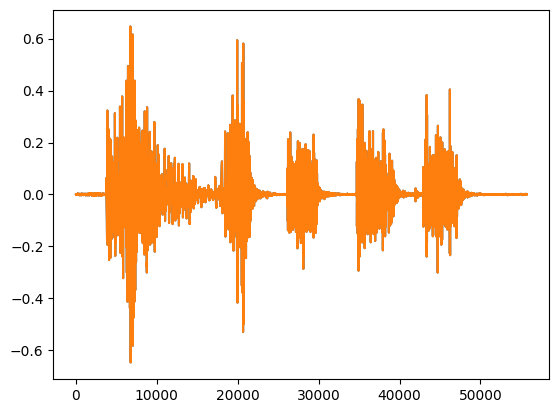

In [ ]:
#| eval: false

data_path = '../aeiou/examples/'
waveform = load_audio(data_path+'example.wav')
stereo_op = Stereo()
waveform = stereo_op(waveform)
print("waveform.shape =",waveform.shape)
#playable_spectrogram(waveform, output_type='live')
for c in range(waveform.shape[0]):
    plt.plot(waveform[c].cpu().numpy())

spec.shape, recon.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])


/admin/home-shawley/envs/aa/lib/python3.8/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


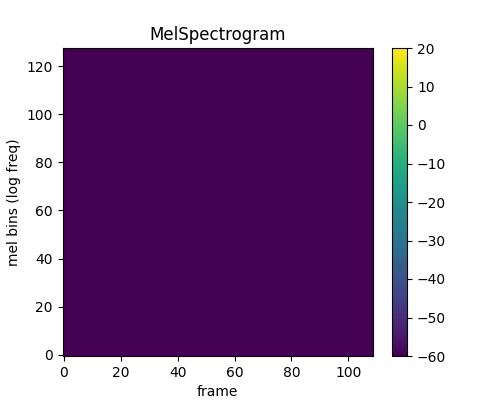

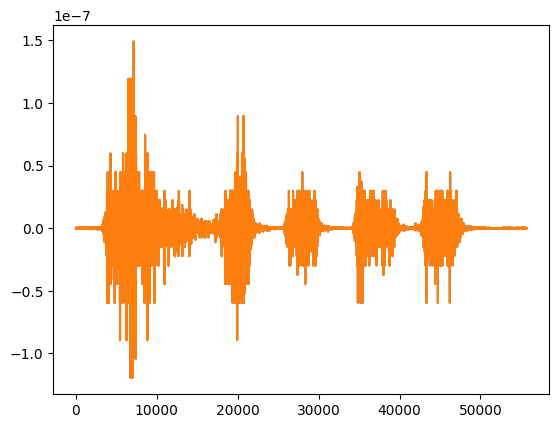

In [ ]:
#| eval: false

specfunc = SpectrogramAE()
spec, recon = specfunc.forward(waveform)
print("spec.shape, recon.shape = ",spec.shape, recon.shape)
diff = recon-waveform

#playable_spectrogram(diff, output_type='live') #plot/play the difference
spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
for c in range(waveform.shape[0]):
    plt.plot(diff[c].cpu().numpy())

In [ ]:
#|export
class MagSpectrogramAE(GivenModelClass):
    "Magnitude spectrogram encoder, GriffinLim decoder"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=2, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        self.decoder = T.GriffinLim(          n_fft=n_fft, hop_length=hop_length, **kwargs)
        
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, reps: torch.Tensor) -> torch.Tensor:
        return self.match_sizes( self.decoder(reps) )

magspec.shape, recon2.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])


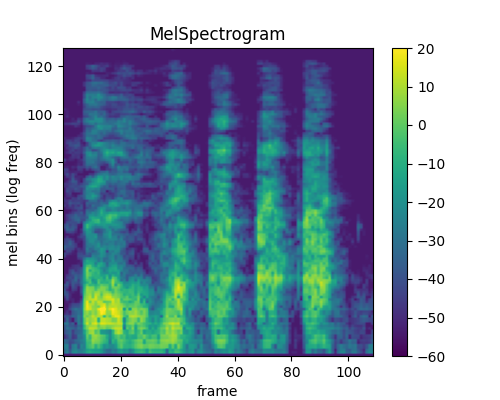

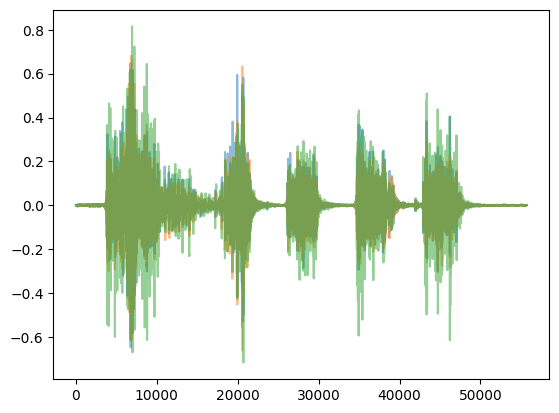

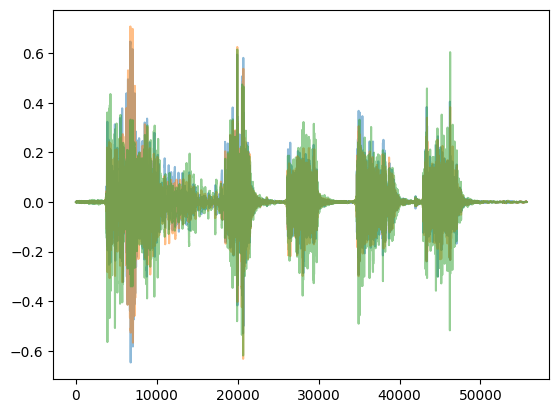

In [ ]:
#| eval: false

# test that
magspecfunc = MagSpectrogramAE()
magspec, recon2 = magspecfunc.forward(waveform)
print("magspec.shape, recon2.shape = ",magspec.shape, recon2.shape )
diff = recon2-waveform

#playable_spectrogram(diff, specs="waveform", output_type='live') #plot/play the difference
spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
c = 0 # show left channel
for thing in [waveform, recon2, diff]:
    plt.plot(thing[c].cpu().numpy(), alpha=0.5)
plt.show()
c = 1  # show right channel
for thing in [waveform, recon2, diff]:
    plt.plot(thing[c].cpu().numpy(), alpha=0.5)
plt.show()

In [ ]:
#|export
class MelSpectrogramAE(GivenModelClass):
    "Mel spectrogram encoder, GriffinLim decoder"
    def __init__(self,
        sample_rate=48000,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)
        inv_melscale_t = T.InverseMelScale(n_stft=n_fft // 2 + 1)  
        self.decoder = T.GriffinLim(n_fft=n_fft, hop_length=hop_length, **kwargs)
        
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, melspec: torch.Tensor) -> torch.Tensor:
        spec = inv_melscale_t(melspec)
        return self.match_sizes( self.decoder(spec) )

melspec.shape, recon3.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])


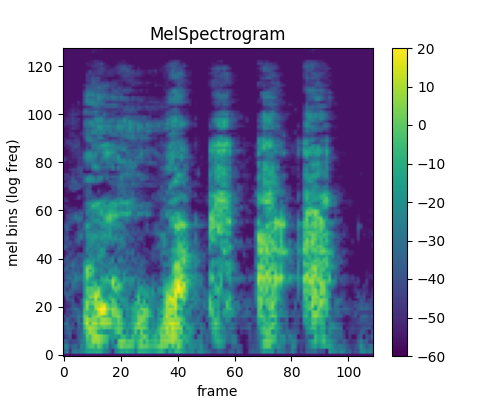

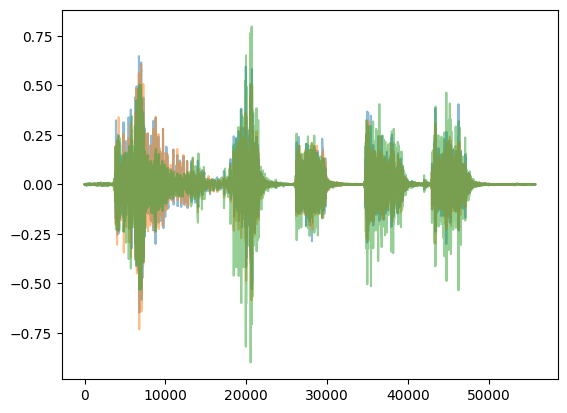

In [ ]:
#| eval: false

# test that
melspecfunc = MelSpectrogramAE()
melspec, recon3 = magspecfunc.forward(waveform)
print("melspec.shape, recon3.shape = ",melspec.shape, recon3.shape )
diff = recon3-waveform

#playable_spectrogram(diff, specs="waveform", output_type='live') #plot/play the difference
spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
c = 0
for thing in [waveform, recon3, diff]:
    plt.plot(thing[c].cpu().numpy(), alpha=0.5)

# Diffusion models

Wrapper for Zach's DVAE model from September/October. This cannot be subclassed from the above `GivenModel` class if we want to be able to import the checkpoint files. 

In [ ]:
#|export
class DVAEWrapper(GivenModelClass):
    "Wrapper for (hawley's fork of) Zach's DiffusionDVAE"
    def __init__(self, 
        args_dict = {'num_quantizers':0, 'sample_size': 65536, 'demo_steps':50, 'sample_rate':48000, 'latent_dim': 64, 'pqmf_bands':1, 'ema_decay':0.995, 'num_quantizers':0},
        device='cuda',
        debug=True,
        **kwargs,
    ):
        super().__init__()
        class DictObj:
            def __init__(self, in_dict:dict):
                for key, val in in_dict.items():
                    if isinstance(val, (list, tuple)):
                        setattr(self, key, [DictObj(x) if isinstance(x, dict) else x for x in val])
                    else:
                        setattr(self, key, DictObj(val) if isinstance(val, dict) else val)
        self.global_args = DictObj(args_dict)
        self.dvae_model = DiffusionDVAE(self.global_args)
        self.device = device
        self.noise = None 
        self.demo_steps = self.global_args.demo_steps
        self.demo_samples = self.global_args.sample_size 
        self.debug = debug
    
    def encode_it(self, demo_reals):
        module = self.dvae_model
        encoder_input = demo_reals
        print("demo_reals.shape = ",demo_reals.shape)

        if module.pqmf_bands > 1:
            encoder_input = module.pqmf(demo_reals)

        encoder_input = encoder_input.to(self.device)
        demo_reals = demo_reals.to(self.device)
        noise = torch.randn([demo_reals.shape[0], 2, self.demo_samples]).to(self.device)

        with torch.no_grad():
            embeddings = module.encoder_ema(encoder_input)
            if module.quantized:
                if debug: print("Hey, did you know you're quantized? ")
                #Rearrange for Memcodes
                embeddings = rearrange(embeddings, 'b d n -> b n d')
                embeddings, _= module.quantizer_ema(embeddings)
                embeddings = rearrange(embeddings, 'b n d -> b d n')
        
        embeddings = torch.tanh(embeddings)
        return embeddings, noise
        
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        self.orig_shape = waveform.shape
        self.demo_samples = waveform.shape[-1]
        reps, self.noise = self.dvae_model.encode_it(waveform)
        return reps

    def decode(self, reps: torch.Tensor) -> torch.Tensor:
        print("reps.shape, self.noise.shape = ",reps.shape, self.noise.shape)
        fake_batches = sample(self.dvae_model.diffusion_ema, self.noise, self.demo_steps, 0, reps)
        recon = rearrange(fake_batches, 'b d n -> d (b n)') # Put the demos together
        return recon
    
    def setup(self, ckpt_file='/fsx/shawley/checkpoints/dvae_checkpoint.ckpt', device='cuda'):
        print(f"DVAE: attempting to load checkpoint {ckpt_file}")
        try:
            self.dvae_model = DiffusionDVAE.load_from_checkpoint(ckpt_file, global_args=self.global_args)
        except Exception as e:
            print(f"Sorry, exception = {e}. Going with random weights")
        self.dvae_model.encode_it = self.encode_it
        self.dvae_model.quantized = self.global_args.num_quantizers > 0 
        self.dvae_model.eval() # disable randomness, dropout, etc...
        self.dvae_model.to(self.device)
        freeze(self.dvae_model)  # freeze the weights for inference

In [ ]:
#| eval: false

# test that
args_dict = {'num_quantizers':0, 'sample_size': waveform.shape[-1], 'demo_steps':50, 'sample_rate':48000, 'latent_dim': 64, 'pqmf_bands':1, 'ema_decay':0.995, 'num_quantizers':0},

dvae = DVAEWrapper()
dvae.setup()

DVAE: attempting to load checkpoint /fsx/shawley/checkpoints/dvae_checkpoint.ckpt


In [ ]:
#| eval: false
waveform2 = dvae.zero_pad_po2(waveform)
waveform_batch = waveform2.unsqueeze(0)
print("waveform_batch.shape =",waveform_batch.shape)
reps = dvae.encode(waveform_batch)
reps.shape

waveform_batch.shape = torch.Size([1, 2, 65536])
demo_reals.shape =  torch.Size([1, 2, 65536])


torch.Size([1, 64, 512])

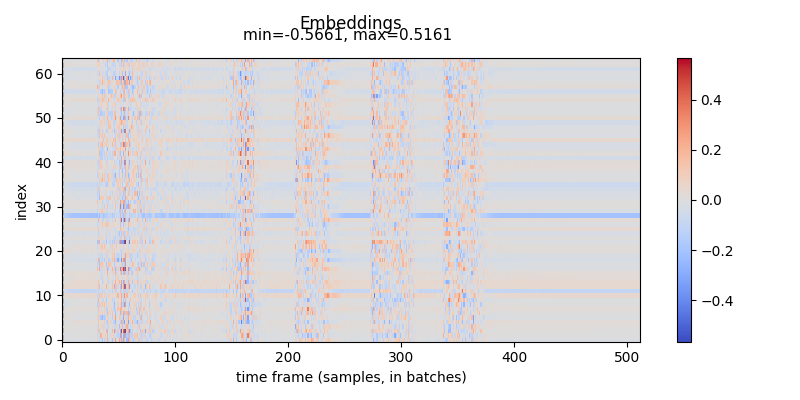

In [ ]:
#| eval: false
tokens_spectrogram_image(reps, mark_batches=True) 

In [ ]:
#| eval: false
recon = dvae.decode(reps)

reps.shape, self.noise.shape =  torch.Size([1, 64, 512]) torch.Size([1, 2, 65536])


100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


torch.Size([1, 2, 65536])
torch.Size([1, 2, 65536])
torch.Size([1, 2, 65536])


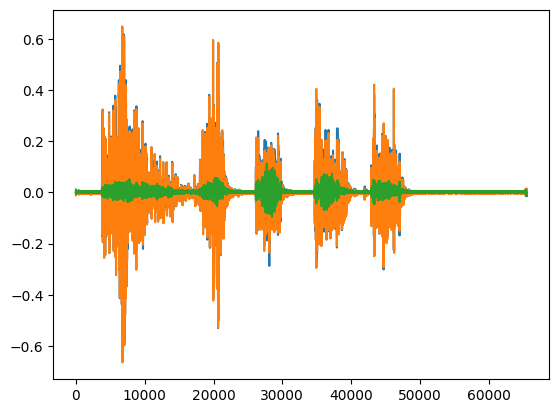

In [ ]:
#| eval: false
#playable_spectrogram(recon, specs='wave_mel', output_type='live')
diff = waveform_batch - recon.cpu()
for thing in [waveform_batch, recon.unsqueeze(0).cpu(), diff]:
    print(thing.shape)
    plt.plot(thing[0,0,:].numpy())

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()